In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.stats import mannwhitneyu
from sklearn.feature_selection import RFECV, RFE
import joblib
from copy import deepcopy
import itertools
from sklearn.metrics import r2_score, roc_curve, auc, confusion_matrix
from scipy.signal import savgol_filter, find_peaks
from scipy.interpolate import interp1d
from statannot import add_stat_annotation
from sklearn.decomposition import PCA
from itertools import chain
import forestci as fci
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from scipy.stats import kruskal

# Prepare input data for machine learning

## read minimum number of features

In [3]:
df_X = pd.read_csv('df_X_cnv_snv.csv', index_col=0)
df_X = df_X[['CPAR2_104610',
             'Contig005809_C_parapsilosis_CDC317:1574350:SNP$HomAlt',
             'CPAR2_104600',
             'Contig005809_C_parapsilosis_CDC317:2251778:SNP$HomAlt',
             'CPAR2_805410',
             'Contig005809_C_parapsilosis_CDC317:1283814:SNP$Het',]]
df_X

,CPAR2_104610,Contig005809_C_parapsilosis_CDC317:1574350:SNP$HomAlt,CPAR2_104600,Contig005809_C_parapsilosis_CDC317:2251778:SNP$HomAlt,CPAR2_805410,Contig005809_C_parapsilosis_CDC317:1283814:SNP$Het
1,28,1,15,1,0,1
2,27,1,15,1,0,1
5,27,1,15,1,0,1
17,27,1,15,1,0,1
18,25,1,14,1,0,1
...,...,...,...,...,...,...
2640,22,1,13,1,0,1
2646,2,1,2,1,0,1
2647,2,1,2,1,0,1
2648,2,1,2,1,0,1


In [4]:
df_X.loc[1666,'CPAR2_805410']

0

## read HR score (make sure df_X and df_Y have rows matched)

In [5]:
df_Y = pd.read_csv('../../quantification/hr_score_msk_strains.csv', index_col=0).loc[df_X.index,['Score','ASV','Is_HR_NMF']]
df_Y = df_Y.loc[df_X.index]
df_Y = df_Y.rename({'Is_HR_NMF':'Is_HR'}, axis=1)
df_Y.loc[df_Y.ASV=='ASV_1','ASV'] = 0
df_Y.loc[df_Y.ASV=='ASV_3','ASV'] = 1
df_Y.head()

,Score,ASV,Is_HR
1,0.813608,1,True
2,0.672028,1,True
5,0.634746,1,True
17,0.438212,1,True
18,0.404098,1,True


## read sample weights

In [6]:
df_weight = pd.read_csv('../../InStrain/strain_clusters.csv', index_col=0)
df_weight = df_weight.loc[df_X.index]
df_weight.head()

,ClusterName,Weight
1,0,0.000891
2,0,0.000891
5,0,0.000891
17,0,0.000891
18,0,0.000891


# Model assessment using cross validation

## using cnv + snv and as predictors

In [7]:
X = df_X.values
y = np.ravel(df_Y.loc[df_X.index,['Score']].values)
y_binary = np.ravel(df_Y.loc[df_X.index,['Is_HR']].values)
W = df_weight.loc[df_X.index,'Weight'].values
param_grid = {
    'max_features':[0.16],
    'max_depth':[4]
}

best_model_set = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y_binary):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    W_train, W_test = W[train_index], W[test_index]
    
    # do internal cross validation to optimize hyperparameters
    rf = RandomForestRegressor(n_estimators=1000,random_state=42)
    CV = GridSearchCV(rf, param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=0)
    CV.fit(X_train, y_train, sample_weight=W_train)
    best_model = CV.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    best_model_set.append([best_model, train_index, X_train, y_train, y_train_pred, test_index, X_test, y_test, y_test_pred])

joblib.dump(best_model_set, "model_assessment_crossval_cnv_snv_parfixed.joblib")

['model_assessment_crossval_cnv_snv_parfixed.joblib']

## Summarize the predictions for the CNV + SNV model

In [8]:
best_model_set = joblib.load('model_assessment_crossval_cnv_snv.joblib')

lines = []
all_genomeIDs = list(df_X.index)
for k in np.arange(len(best_model_set)):
    test_index = best_model_set[k][5]
    y_test = best_model_set[k][7]
    y_test_pred = best_model_set[k][8]
    
    # estimate variance
    X_train = best_model_set[k][2]
    X_test = best_model_set[k][6]
    model = best_model_set[k][0]
    variance = fci.random_forest_error(model, X_train, X_test)
    for ti, y1, y2, var in zip(test_index, y_test, y_test_pred, variance):
        y1_label = df_Y.loc[all_genomeIDs[ti], 'Is_HR']
        y2_label = y2>=0.22
        if y1_label != y2_label:
            if y1_label == 0 and y2_label == 1:
                lines.append([k+1, all_genomeIDs[ti], y1, y2, np.sqrt(var), y1_label, y2_label, 'FP'])
            else:
                lines.append([k+1, all_genomeIDs[ti], y1, y2, np.sqrt(var), y1_label, y2_label, 'FN'])
        else:
            if y1_label == 0 and y2_label == 0:
                lines.append([k+1, all_genomeIDs[ti], y1, y2, np.sqrt(var), y1_label, y2_label, 'TN'])
            else:
                lines.append([k+1, all_genomeIDs[ti], y1, y2, np.sqrt(var), y1_label, y2_label, 'TP'])
                              
df_summary = pd.DataFrame(lines, columns=['Fold','GenomeID','HR_obs','HR_pred','Std','HR_label_obs','HR_label_pred','Outcome'])
df_summary.to_csv('Prediction_summary_cnv_snv_model_parfixed.csv', index=False)
df_summary.head()

,Fold,GenomeID,HR_obs,HR_pred,Std,HR_label_obs,HR_label_pred,Outcome
0,1,5,0.634746,0.576085,0.040710,True,True,TP
1,1,18,0.404098,0.539784,0.038952,True,True,TP
2,1,49,0.476159,0.576085,0.040710,True,True,TP
3,1,250,0.013358,0.049154,0.038293,False,False,TN
4,1,264,0.471364,0.577341,0.041270,True,True,TP


In [9]:
df_summary[df_summary.Outcome.isin(['FP','FN'])]

,Fold,GenomeID,HR_obs,HR_pred,Std,HR_label_obs,HR_label_pred,Outcome
19,1,2384,0.400334,0.184418,0.038092,True,False,FN
31,2,813,0.043253,0.418083,0.054365,False,True,FP
40,2,2191,0.318113,0.027994,0.037704,True,False,FN
55,3,809,0.317588,0.204311,0.073510,True,False,FN
62,3,1398,0.152333,0.506859,0.064610,False,True,FP
68,3,2159,0.012660,0.512462,0.067538,False,True,FP
105,5,800,0.186613,0.320397,0.098115,False,True,FP


## Show cross validation scatterplot

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/forestci/calibration.py:86: RuntimeWarning: overflow encountered in exp
  g_eta_raw = np.exp(np.dot(XX, eta)) * mask
/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/forestci/calibration.py:86: RuntimeWarning: overflow encountered in exp
  g_eta_raw = np.exp(np.dot(XX, eta)) * mask
/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/forestci/calibration.py:86: RuntimeWarning: overflow encountered in exp
  g_eta_raw = np.exp(np.dot(XX, eta)) * mask


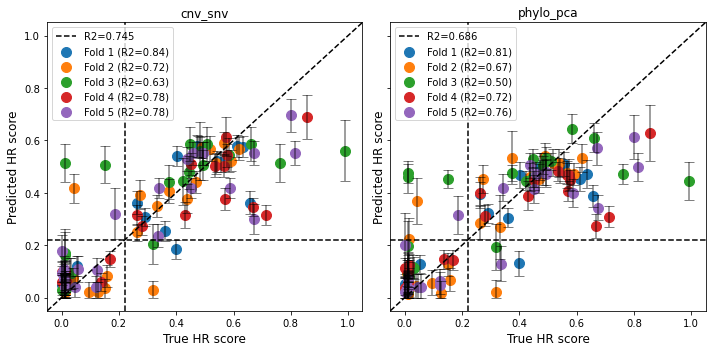

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharex=True, sharey=True)

for i,key in enumerate(['cnv_snv','phylo_pca']):
    colidx = i%2
    
    best_model_set = joblib.load('model_assessment_crossval_%s.joblib'%(key))
    y_test_all = []
    y_pred_all = []
    for k in np.arange(len(best_model_set)):
        y_test = best_model_set[k][7]
        y_test_pred = best_model_set[k][8]
        X_train = best_model_set[k][2]
        X_test = best_model_set[k][6]
        model = best_model_set[k][0]
        variance = fci.random_forest_error(model, X_train, X_test)
        std = [np.sqrt(v) for v in variance]
        std_up = [std if mean+std<=1 else 1-mean for std, mean in zip(std, y_test_pred)]
        std_down = [std if mean-std>=0 else mean for std, mean in zip(std, y_test_pred)]
        
        r2 = r2_score(y_pred=y_test_pred, y_true=y_test)
        _ = ax[colidx].scatter(y_test, y_test_pred, label='Fold %d (R2=%0.2f)'%(k+1,r2), s=100, marker='o')
        _ = ax[colidx].errorbar(y_test, y_test_pred, yerr=[std_down,std_up], capsize=5, fmt='none', color='k', alpha=0.5)
        
        y_test_all.extend(y_test)
        y_pred_all.extend(y_test_pred)
    r2_all = r2_score(y_pred=y_pred_all, y_true=y_test_all)
    _ = ax[colidx].plot([-0.05,1.05], [-0.05,1.05], 'k--', label='R2=%0.3f'%(r2_all))
    _ = ax[colidx].plot([-0.05,1.05], [0.22,0.22], 'k--')
    _ = ax[colidx].plot([0.22,0.22], [-0.05,1.05], 'k--')
    _ = ax[colidx].legend()
    _ = ax[colidx].set_xlim([-0.05,1.05])
    _ = ax[colidx].set_ylim([-0.05,1.05])
    _ = ax[colidx].set_xlabel('True HR score', fontsize=12)
    _ = ax[colidx].set_ylabel('Predicted HR score', fontsize=12)
    _ = ax[colidx].set_title(key)
    
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("model_comparison_r2_parfixed.svg")